In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results
from misc.viz import imshow
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('../logs/store/results_df.pkl')
df

,run_id,lr,net,bias,name,seed,tags,test,n_val,train,...,num_workers,space_length,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss
0,2m7eu5tn,0.0010,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,worldly-snowflake-183,[0.0004728641652036458]
1,ugylvzz6,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,classic-glade-184,[0.009488677605986595]
2,unpw27ml,0.1000,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,sage-river-182,[0.0035890007857233286]
3,w4yjcu25,0.0100,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,azure-grass-181,[0.0031849860679358244]
4,q86f7s5e,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,blooming-star-180,[0.02364257164299488]
5,23tbcas1,0.0010,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,electric-cosmos-179,[0.011470845900475979]
6,vw4gomv4,0.1000,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,lyric-blaze-178,[0.10497400164604187]
7,r6ilnqy7,0.0100,TrainP,False,None,5.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,snowy-haze-177,[0.023234985768795013]
8,wumlcc9g,0.0010,TrainP,False,None,4.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,tough-dream-175,[0.0005002270918339491]
9,t0m1gmbl,0.0001,TrainP,False,None,4.0,[v5],True,100.0,True,...,18.0,7.0,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,fine-frog-176,[0.008932985365390778]


In [52]:
df_v5 = df[df['tags'].astype(str).str.contains('v5')]
df_v5['test_loss'] = df_v5['test_loss'].astype(float)

In [60]:
run_ids = df_v5[(df_v5['lr'] == 0.001) & (df_v5['n_train'] == 10_000)]['run_id'].values

In [77]:
P_dir = '../logs/store/P/'

npu = NumpyUtils(dir = P_dir)
Ps = {run_id: npu.load(run_id) for run_id in tqdm(run_ids, leave=False)}
Ps_array = np.array(list(Ps.values()))

In [80]:
Ps_array

array([[[ 2.1465273 ,  0.5118638 , -1.4161533 , ..., -1.5310299 ,
         -0.28795776, -0.5887528 ],
        [ 0.91931355,  0.4689858 ,  0.43658555, ..., -0.41603547,
          0.2763254 , -1.7111584 ],
        [ 0.62887174, -2.0006282 ,  0.1005771 , ...,  0.6630132 ,
         -0.9503757 , -0.98250175],
        ...,
        [ 0.51184046,  1.0171272 ,  0.21487394, ..., -1.1071765 ,
          0.10788131, -0.5576322 ],
        [-0.6080637 ,  0.32362258, -0.264464  , ..., -1.6654371 ,
          1.3535056 ,  0.37845826],
        [-1.5061336 , -1.3545781 , -0.42104182, ..., -1.8227649 ,
         -0.31854895, -1.0481161 ]],

       [[-1.1060088 ,  1.2400032 ,  0.40283015, ..., -0.3369692 ,
         -1.0142059 ,  0.616472  ],
        [-0.44799823,  2.1870542 ,  1.5378758 , ..., -0.55853057,
         -2.0008779 , -1.0810724 ],
        [ 1.7416807 ,  0.4476581 ,  0.09050039, ..., -1.5524039 ,
         -0.55676043, -0.32442003],
        ...,
        [ 0.81434923,  1.4386965 , -0.9788595 , ...,  

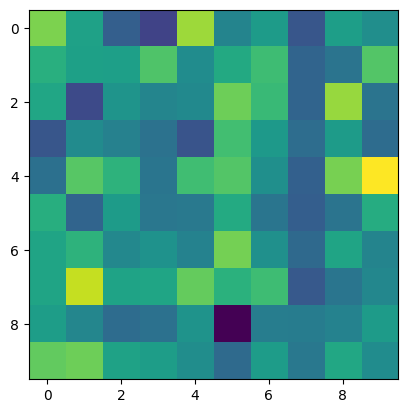

In [81]:
plt.imshow(Ps_array[0][:10, :10])

In [ ]:
    #     array = np.load(os.path.join(store_dir, store_dir_dir, f'{id}.npy'))    
    #     config[store_dir_dir] = array

In [28]:
lrs = df_v5['lr'].unique()
n_train = df_v5['n_train'].unique()
seed = df_v5['seed'].unique()

In [49]:
df_v5_agg = df_v5.groupby(['lr', 'n_train'])['test_loss']
means = df_v5_agg.mean()
stds = df_v5_agg.std()

means

lr      n_train
0.0001  1000.0     0.023878
        10000.0    0.009311
0.0010  1000.0     0.011597
        10000.0    0.000490
0.0100  1000.0     0.022928
        10000.0    0.003206
0.1000  1000.0     0.099470
        10000.0    0.003027
Name: test_loss, dtype: float64

In [43]:
df_v5[(df_v5['lr'] == 0.0001) & (df_v5['n_train'] == 1000)]['test_loss'].mean()

0.023878485336899756

In [48]:
for lr in lrs:
    for n in n_train:
        print(f'lr: {lr}, n_train: {n}')
        print(f'mean: {means[lr][n]}, std: {stds[lr][n]}')

lr: 0.001, n_train: 10000.0
mean: 0.0004903466324321926, std: 4.631198272287724e-05
lr: 0.001, n_train: 1000.0
mean: 0.011597345769405364, std: 0.0006435792996111161
lr: 0.0001, n_train: 10000.0
mean: 0.009310855902731419, std: 0.0002827898501148915
lr: 0.0001, n_train: 1000.0
mean: 0.023878485336899756, std: 0.0012433230968027036
lr: 0.1, n_train: 10000.0
mean: 0.003027223888784647, std: 0.000677990662473712
lr: 0.1, n_train: 1000.0
mean: 0.09946968853473663, std: 0.0052732493963134
lr: 0.01, n_train: 10000.0
mean: 0.0032063113059848545, std: 0.00033237877300813096
lr: 0.01, n_train: 1000.0
mean: 0.022928406298160554, std: 0.0007944920973737778
